In this project, we are going to look at 'bike_rental_hour.csv', a dataset that contains the hourly and daily count of rental bikes between years 2011 and 2012 in the Capital bikeshare system. From the dataset, we are going to apply various machine learning algorithms to generate a model that can predict the number of bike rentals.

For more information on this dataset click [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

instant - A unique sequential ID number for each row<br>
dteday - The date of the rentals<br>
season - The season in which the rentals occurred<br>
yr - The year the rentals occurred<br>
mnth - The month the rentals occurred<br>
hr - The hour the rentals occurred<br>
holiday - Whether or not the day was a holiday<br>
weekday - The day of the week (as a number, 0 to 7)<br>
workingday - Whether or not the day was a working day<br>
weathersit - The weather (as a categorical variable)<br>
temp - The temperature, on a 0-1 scale<br>
atemp - The adjusted temperature<br>
hum - The humidity, on a 0-1 scale<br>
windspeed - The wind speed, on a 0-1 scale<br>
casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)<br>
registered - The number of registered riders (people who had already signed up)<br>
cnt - The total number of bike rentals (casual + registered)<br>

In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

### Data Analysis and Feature Engineering

---
Make a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals.
Use the corr method on the bike_rentals dataframe to explore how each column is correlated with cnt.

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

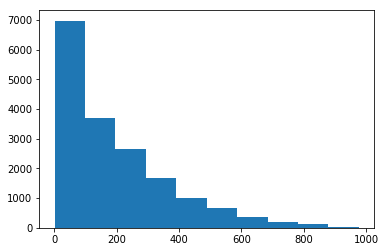

In [2]:
plt.hist(bike_rentals['cnt'])

In [3]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Using a histogram, we've quickly plotted the distribution of the 'cnt' column. This is the total number of bike rentals for a particular hour of a day. We can see that this is a right skewed distribution. The 50% percentile, or the median is 142. 

We can add a feature to the dataset. By splitting the day to four time brackets, we can create a new column, 'time_label'.

In [4]:
def assign_label(hour):
    if hour > 6 and hour <= 12:
        return 1
    elif hour > 12 and hour <= 18:
        return 2
    elif hour > 18 and hour <= 24:
        return 3
    else:
        return 4

In [5]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

Next, Let's take a look at the correlation of this dataset.

In [6]:
bike_rentals.corr()

instant    season        yr      mnth        hr   holiday  \
instant     1.000000  0.404046  0.866014  0.489164 -0.004775  0.014723   
season      0.404046  1.000000 -0.010742  0.830386 -0.006117 -0.009585   
yr          0.866014 -0.010742  1.000000 -0.010473 -0.003867  0.006692   
mnth        0.489164  0.830386 -0.010473  1.000000 -0.005772  0.018430   
hr         -0.004775 -0.006117 -0.003867 -0.005772  1.000000  0.000479   
holiday     0.014723 -0.009585  0.006692  0.018430  0.000479  1.000000   
weekday     0.001357 -0.002335 -0.004485  0.010400 -0.003498 -0.102088   
workingday -0.003416  0.013743 -0.002196 -0.003477  0.002285 -0.252471   
weathersit -0.014198 -0.014524 -0.019157  0.005400 -0.020203 -0.017036   
temp        0.136178  0.312025  0.040913  0.201691  0.137603 -0.027340   
atemp       0.137615  0.319380  0.039222  0.208096  0.133750 -0.030973   
hum         0.009577  0.150625 -0.083546  0.164411 -0.276498 -0.010588   
windspeed  -0.074505 -0.149773 -0.008740 -0.135386  0.137252  0.003988   
casual      0.158295  0.120206  0.142779  0.068457  0.301202  0.031564   
registered  0.282046  0.174226  0.253684  0.122273  0.374141 -0.047345   
cnt         0.278379  0.178056  0.250495  0.120638  0.394071 -0.030927   
time_label  0.006533  0.006467  0.004770  0.005782 -0.305052 -0.000586   

             weekday  workingday  weathersit      temp     atemp       hum  \
instant     0.001357   -0.003416   -0.014198  0.136178  0.137615  0.009577   
season     -0.002335    0.013743   -0.014524  0.312025  0.319380  0.150625   
yr         -0.004485   -0.002196   -0.019157  0.040913  0.039222 -0.083546   
mnth        0.010400   -0.003477    0.005400  0.201691  0.208096  0.164411   
hr         -0.003498    0.002285   -0.020203  0.137603  0.133750 -0.276498   
holiday    -0.102088   -0.252471   -0.017036 -0.027340 -0.030973 -0.010588   
weekday     1.000000    0.035955    0.003311 -0.001795 -0.008821 -0.037158   
workingday  0.035955    1.000000    0.044672  0.055390  0.054667  0.015688   
weathersit  0.003311    0.044672    1.000000 -0.102640 -0.105563  0.418130   
temp       -0.001795    0.055390   -0.102640  1.000000  0.987672 -0.069881   
atemp      -0.008821    0.054667   -0.105563  0.987672  1.000000 -0.051918   
hum        -0.037158    0.015688    0.418130 -0.069881 -0.051918  1.000000   
windspeed   0.011502   -0.011830    0.026226 -0.023125 -0.062336 -0.290105   
casual      0.032721   -0.300942   -0.152628  0.459616  0.454080 -0.347028   
registered  0.021578    0.134326   -0.120966  0.335361  0.332559 -0.273933   
cnt         0.026900    0.030284   -0.142426  0.404772  0.400929 -0.322911   
time_label  0.002636   -0.000640   -0.031821 -0.112537 -0.107018  0.240154   

            windspeed    casual  registered       cnt  time_label  
instant     -0.074505  0.158295    0.282046  0.278379    0.006533  
season      -0.149773  0.120206    0.174226  0.178056    0.006467  
yr          -0.008740  0.142779    0.253684  0.250495    0.004770  
mnth        -0.135386  0.068457    0.122273  0.120638    0.005782  
hr           0.137252  0.301202    0.374141  0.394071   -0.305052  
holiday      0.003988  0.031564   -0.047345 -0.030927   -0.000586  
weekday      0.011502  0.032721    0.021578  0.026900    0.002636  
workingday  -0.011830 -0.300942    0.134326  0.030284   -0.000640  
weathersit   0.026226 -0.152628   -0.120966 -0.142426   -0.031821  
temp        -0.023125  0.459616    0.335361  0.404772   -0.112537  
atemp       -0.062336  0.454080    0.332559  0.400929   -0.107018  
hum         -0.290105 -0.347028   -0.273933 -0.322911    0.240154  
windspeed    1.000000  0.090287    0.082321  0.093234   -0.152740  
casual       0.090287  1.000000    0.506618  0.694564   -0.354446  
registered   0.082321  0.506618    1.000000  0.972151   -0.477057  
cnt          0.093234  0.694564    0.972151  1.000000   -0.494422  
time_label  -0.152740 -0.354446   -0.477057 -0.494422    1.000000

In [7]:
corr=bike_rentals.corr()
corr_cnt=corr['cnt'].sort_values(ascending=False)
print(corr_cnt)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
time_label   -0.494422
Name: cnt, dtype: float64


We are not really seeing very strong correlations in these columns. The 'casual' and 'registered' columns are simply subcategories of the 'cnt' column. These columns leak information on the target column so we'll have to drop them. The 'dteday' column is just the date, and can't be used in this machine learning exercise.


In [8]:
columns = bike_rentals.columns.drop(['cnt', 'casual', 'dteday', 'registered'])
columns

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

### Applying Machine Learning

---

In order to prepare for machine learning, we'll need to split the data into a training set and a testing set. We can use the math module to randomly sample 80% of the data and assign it to the training set. Then we can use the remaining 20% as the testing set.

We will use MSE for the evauation of this machine learning algorithm. MSE works well since the target column 'cnt' is continuous.

In [9]:
import math

#Sample 80% of the data randomly and assigns it to train.
train = bike_rentals.sample(frac=0.8, random_state=1)
test = bike_rentals.drop(train.index)

Now that you've done some exploration and manipulation, you're ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

As you learned in earlier missions, linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

You'll need to ignore the casual and registered columns because cnt is derived from them. If you're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that you'd already know casual or registered, because those numbers are added together to get cnt.

In [10]:
lr = LinearRegression()
lr.fit(train[columns], train['cnt'])
predictions_test = lr.predict(test[columns])
mse_test = mean_squared_error(test['cnt'], predictions_test)
rmse_test=np.sqrt(mse_test)
print("mse_test",mse_test)
print("rmse_test",rmse_test)
print("target range", bike_rentals["cnt"].min(), "-", bike_rentals["cnt"].max())
print("target sd", np.std(bike_rentals["cnt"]))

mse_test 15848.500195099274
rmse_test 125.89082649303433
target range 1 - 977
target sd 181.38238043116962


In [11]:
#Verify overfitting
predictions_train = lr.predict(train[columns])
rmse_train = np.sqrt(mean_squared_error(train['cnt'], predictions_train))
rmse_train

127.52375688945615

Both the training set and the test set showed high error.The linear regression model is probably not the best for this dataset. We can use the decision tree to see if we can improve our predictions. The linear regression method is great for datasets with lots of continuous data, but a lot of the columns in this dataset is not continuous, but rather categorical.

Let's start by using a single tree model.

In [12]:
tree=DecisionTreeRegressor()
tree.fit(train[columns],train['cnt'])
predictions=tree.predict(test[columns])
rmse_tree=np.sqrt(mean_squared_error(test['cnt'],predictions))
print(rmse_tree)

56.2618712700104


In [13]:
tree = DecisionTreeRegressor(min_samples_leaf=5)
tree.fit(train[columns], train['cnt'])
predictions = tree.predict(test[columns])

rmse_tree_msl5 =np.sqrt(mean_squared_error(test['cnt'], predictions))
print(rmse_tree_msl5)

#Verify the overfitting
predictions=tree.predict(train[columns])
rmse_tree_ms15_train=np.sqrt(mean_squared_error(train['cnt'],predictions))
print(rmse_tree_ms15_train)

52.31796183040693
31.658584886317747


As we can see, the decision tree model reduced our error signficantly. Unfortunately due to large difference in error between predictions on the tree's training vs. testing set, it looks like there are overfitting / sensitivity issues.
We can further improve our results if we use a forest of decision trees to reduce overfitting.

In [14]:
tree = RandomForestRegressor(min_samples_leaf=2, n_estimators=250)
tree.fit(train[columns], train['cnt'])
predictions = tree.predict(test[columns])

rmse = np.sqrt(mean_squared_error(test['cnt'], predictions))
print(rmse)

#Verify overfitting
predictions_train=tree.predict(train[columns])
rmse_train=np.sqrt(mean_squared_error(train['cnt'],predictions_train))
print(rmse_train)

42.80306356170131
20.568028902614955


We specified the hyperparameter values 'min_samples_leaf' and 'n_estimators', we can optimize these values by using a for loop.

In [15]:
rmse_leaf=[]
for i in range(1, 10):
    tree = RandomForestRegressor(min_samples_leaf=i, n_estimators=250)
    tree.fit(train[columns], train['cnt'])
    predictions = tree.predict(test[columns])

    rmse = np.sqrt(mean_squared_error(test['cnt'], predictions))
    rmse_leaf.append(rmse)
rmse_leaf


[42.759743463003424,
 43.111255887733904,
 43.92828833111811,
 44.55769290851666,
 45.04599387588375,
 45.58205414922737,
 46.207653660882464,
 46.92592827103548,
 47.698749737864475]

In [16]:
n_trees = [250, 500, 750]
rmse_trees=[]
for i in n_trees:
    tree = RandomForestRegressor(min_samples_leaf=1, n_estimators=i)
    tree.fit(train[columns], train['cnt'])
    predictions = tree.predict(test[columns])

    rmse = np.sqrt(mean_squared_error(test['cnt'], predictions))
    rmse_trees.append(rmse)
rmse_trees

[42.85314724713974, 42.64838534492653, 42.64579868125347]

Using 750 trees and 1 min_samples_leaf, we managed to slightly lower the RMSE down to 42,65. The random forest regressor is a powerful tool. However, using a large amount of trees in conjunction with a for loop takes a very long time to process.

---

